# 🕵️‍♀️ AT&T Spam Detector 🕵️‍♀️
One of the main pain point that AT\&T users are facing is constant exposure to SPAM messages.
AT\&T has been able to manually flag spam messages for a time, but they are looking for an automated way of detecting spams to protect their users.

## 🎯 Goals 
Our goal is to build a spam detector, that can automatically flag spams as they come based sollely on the sms' content.

## 📚 Imports and installations

In [ ]:
pip install spacy -q

In [ ]:
import pandas as pd
import numpy as np

import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()
from spacy.lang.en.stop_words import STOP_WORDS

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf 
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPool1D, BatchNormalization
from sklearn.metrics import classification_report,confusion_matrix

import warnings
warnings.filterwarnings("ignore")

## 🧹 Data cleaning

In [ ]:
df = pd.read_csv('https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/project/spam.csv', encoding = "ISO-8859-1")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
df.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


In [ ]:
df = df[['v1', 'v2']]
df.columns = ['label', 'message']
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.drop_duplicates(inplace = True)

In [ ]:
df['label'].value_counts()

ham     4516
spam     653
Name: label, dtype: int64

In [ ]:
df['label'] = df['label'].apply(lambda x: 1 if x == 'spam' else 0)

## ⚙️ Data preprocessing

In [ ]:
df['text_clean'] = df['message'].apply(lambda x: ''.join(ch for ch in x if ch.isalpha() or ch==" "))
df['text_clean'] = df['text_clean'].fillna('').apply(lambda x: x.lower())
df.head()

,label,message,text_clean
0,0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final...
3,0,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...


In [ ]:
df['processed_documents'] = df['text_clean'].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000, oov_token="out_of_vocab") 
tokenizer.fit_on_texts(df['processed_documents']) 
df['text_encoded'] = tokenizer.texts_to_sequences(df['processed_documents'])
df['len_text'] = df['text_encoded'].apply(lambda x: len(x))
df = df[df['len_text']!=0]
df.head()

,label,message,text_clean,processed_documents,text_encoded,len_text
0,0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...,jurong point crazy available bugis n great wor...,"[1, 209, 399, 467, 818, 34, 54, 260, 673, 76, ...",14
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni,ok lar joking wif u oni,"[10, 175, 1, 261, 2, 1]",6
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final...,free entry wkly comp win fa cup final tkts s...,"[11, 333, 674, 675, 41, 1, 820, 445, 1, 152, 2...",18
3,0,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,u dun early hor u c,"[2, 113, 133, 1, 2, 81]",6
4,0,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...,nah think usf live,"[635, 20, 575, 146]",4


In [ ]:
train_pad = tf.keras.preprocessing.sequence.pad_sequences(df['text_encoded'], padding="post")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_pad, df['label'], test_size=0.2, stratify=df['label'])

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [ ]:
train_ds = train_ds.shuffle(len(train_ds)).batch(64)
test_ds = test_ds.shuffle(len(test_ds)).batch(64)

## 🧠 Deep learning model

In [ ]:
embedding_dim=8 

vocab_size = tokenizer.num_words 

model = Sequential([
  Embedding(vocab_size, embedding_dim, name='embedding'), 
  GlobalMaxPool1D(), 
  Dense(16, activation='relu'), 
  Dense(1, activation='sigmoid') 
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 8)           8000      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 8)                0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 16)                144       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 8,161
Trainable params: 8,161
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20)

Epoch 1/20
65/65 [==============================] - 1s 6ms/step - loss: 0.6338 - accuracy: 0.8694 - val_loss: 0.5531 - val_accuracy: 0.8729
Epoch 2/20
65/65 [==============================] - 0s 4ms/step - loss: 0.4674 - accuracy: 0.8733 - val_loss: 0.3847 - val_accuracy: 0.8729
Epoch 3/20
65/65 [==============================] - 0s 4ms/step - loss: 0.3391 - accuracy: 0.8733 - val_loss: 0.2948 - val_accuracy: 0.8729
Epoch 4/20
65/65 [==============================] - 0s 4ms/step - loss: 0.2644 - accuracy: 0.8735 - val_loss: 0.2232 - val_accuracy: 0.8797
Epoch 5/20
65/65 [==============================] - 0s 4ms/step - loss: 0.1994 - accuracy: 0.9131 - val_loss: 0.1672 - val_accuracy: 0.9486
Epoch 6/20
65/65 [==============================] - 0s 4ms/step - loss: 0.1502 - accuracy: 0.9505 - val_loss: 0.1304 - val_accuracy: 0.9651
Epoch 7/20
65/65 [==============================] - 0s 4ms/step - loss: 0.1163 - accuracy: 0.9670 - val_loss: 0.1055 - val_accuracy: 0.9719
Epoch 8/20
65/65 [==

## 📈 Visualization of the model performance

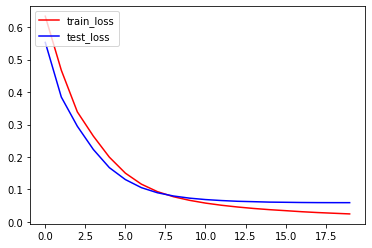

In [ ]:
plt.plot(model.history.history["loss"], c="r", label="train_loss")
plt.plot(model.history.history["val_loss"], c="b", label="test_loss")
plt.legend(loc="upper left")
plt.show()

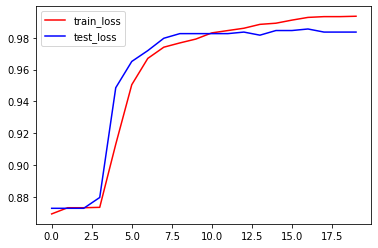

In [ ]:
plt.plot(model.history.history["accuracy"], c="r", label="train_loss")
plt.plot(model.history.history["val_accuracy"], c="b", label="test_loss")
plt.legend(loc="upper left")
plt.show()

In [ ]:
prediction = model.predict(X_test)
classes_pred = [round(pred[0]) for pred in prediction]

print(classification_report(y_test, classes_pred))

33/33 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       900
           1       0.95      0.92      0.93       131

    accuracy                           0.98      1031
   macro avg       0.97      0.95      0.96      1031
weighted avg       0.98      0.98      0.98      1031



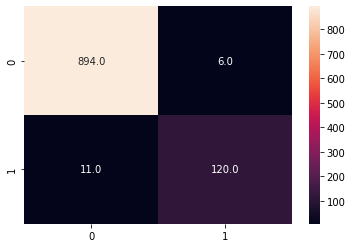

In [ ]:
import seaborn as sns
conf_mat = confusion_matrix(y_test, classes_pred)

sns.heatmap(conf_mat, annot = True, fmt=".1f")
plt.show()